Credit [DNN tutorial](https://becominghuman.ai/build-your-own-neural-network-for-cifar-10-using-pytorch-9bdffb389b7a)

In [1]:
import numpy as np
import cv2
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
FILE_PATH = '/content/drive/MyDrive/CV_Project_Workspace/Project_Code/RNN_multimodal_data/'
ACTORS = ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 
          'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 
          'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 
          'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']
EMOTIONS = {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}

In [3]:
# Load preprocessed data for DNN
# example num = 24 * 60
# sequence length = 5
# input size = 4624 + 128*24
fetched_data = np.zeros([24 * 60, 5, 4624+3072])
labels = np.zeros([24 * 60, 5])
data_index = 0

for actor in ACTORS:
  print(actor)
  file_path = FILE_PATH + actor + '/'
  for dirname, _, files in os.walk(file_path):
    for CURRENT_FILE in files:      
      if CURRENT_FILE[21:] != 'face.csv':
        continue
      VIDEO_PATH = os.path.join(dirname, CURRENT_FILE)
      AUDIO_PATH = dirname+CURRENT_FILE[:21]+'audio.csv'
      video = []
      audio = []
      with open(VIDEO_PATH, 'r') as x:
        data = list(csv.reader(x, delimiter=","))
        video = np.array(data)    # (5, 4624)
      with open(AUDIO_PATH, 'r') as x:
        data = list(csv.reader(x, delimiter=","))
        audio = np.array(data)    # (5, 3072)
      fetched_data[data_index] = np.concatenate([video, audio], axis=1)
      label = int(CURRENT_FILE[7])-1
      labels[data_index] = np.full(5, label)
      data_index += 1

Actor_01
Actor_02
Actor_03
Actor_04
Actor_05
Actor_06
Actor_07
Actor_08
Actor_09
Actor_10
Actor_11
Actor_12
Actor_13
Actor_14
Actor_15
Actor_16
Actor_17
Actor_18
Actor_19
Actor_20
Actor_21
Actor_22
Actor_23
Actor_24


In [4]:
print(fetched_data[-1])

[[  0.          18.11077028  34.525353   ... -63.49890359 -67.19394081
  -40.11380461]
 [  0.          19.10497317  37.33630941 ... -69.48540507 -80.
  -68.29385923]
 [  0.          16.03121954  32.38826948 ... -80.         -80.
  -80.        ]
 [  0.          18.02775638  36.34556369 ... -76.35828923 -80.
  -80.        ]
 [  0.          18.11077028  35.51056181 ... -74.97122892 -74.97122892
  -74.97122892]]


In [5]:
import random
# example num = 24 * 60
# sequence length = 5
# input size = 4624 / 2816

example_nums = fetched_data.shape[0]
train_example_nums = int(0.8 * example_nums)
test_example_nums = int(0.2 * example_nums)

random_ids = [i for i in range(example_nums)]
random.Random(4).shuffle(random_ids)

random_train_ids = random_ids[:train_example_nums]
random_test_ids = random_ids[train_example_nums:]

print(len(random_train_ids), len(random_test_ids))


X_train = torch.as_tensor(fetched_data[random_train_ids,:,:])
Y_train = torch.as_tensor(labels[random_train_ids,:]).type(torch.int64)

X_test = torch.as_tensor(fetched_data[random_test_ids,:,:])
Y_test = torch.as_tensor(labels[random_test_ids,:]).type(torch.int64)

1152 288


In [6]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y):
    self.labels = Y
    self.features = X

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    feature = self.features[index]
    label = self.labels[index]
    return feature, label

In [7]:
train_dataset = Dataset(X_train, Y_train)
test_dataset = Dataset(X_test, Y_test)

print(Y_train)
print(Y_test)
print(X_train)
print(X_test)

tensor([[3, 3, 3, 3, 3],
        [2, 2, 2, 2, 2],
        [1, 1, 1, 1, 1],
        ...,
        [5, 5, 5, 5, 5],
        [2, 2, 2, 2, 2],
        [4, 4, 4, 4, 4]])
tensor([[0, 0, 0, 0, 0],
        [3, 3, 3, 3, 3],
        [7, 7, 7, 7, 7],
        ...,
        [4, 4, 4, 4, 4],
        [3, 3, 3, 3, 3],
        [1, 1, 1, 1, 1]])
tensor([[[  0.0000,  18.2483,  36.4966,  ..., -66.5425, -67.0510, -60.6949],
         [  0.0000,  18.1108,  35.3553,  ..., -77.9505, -79.7976, -58.8061],
         [  0.0000,  17.0000,  34.0000,  ..., -68.9946, -75.5758, -80.0000],
         [  0.0000,  18.0278,  35.2278,  ..., -68.2551, -80.0000, -55.3663],
         [  0.0000,  17.0294,  34.2345,  ..., -80.0000, -80.0000, -80.0000]],

        [[  0.0000,  20.0998,  40.1995,  ..., -78.3359, -72.0426, -64.6250],
         [  0.0000,  21.0950,  41.0488,  ..., -80.0000, -80.0000, -80.0000],
         [  0.0000,  20.0000,  40.0125,  ..., -70.5937, -71.4776, -67.5536],
         [  0.0000,  20.0250,  40.0500,  ..., -77.2655

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
def accuracy(outputs, labels):
    _, seq_preds = torch.max(outputs, dim=1)
    seq_acc = torch.tensor(torch.sum(seq_preds == labels).item() / (seq_preds.shape[0]*seq_preds.shape[1]))
    _, final_preds = torch.max(outputs[:, :, -1], dim=1)
    final_acc = torch.tensor(torch.sum(final_preds == labels[:, -1]).item() / (len(labels)))
    return seq_acc, final_acc

In [11]:
class EmotionClassificationBase(nn.Module):
    def training_step(self, batch):
        features, labels = batch 
        face = features[:,:,:4624]
        audio = features[:,:,4624:]
        out = self(face.type(torch.FloatTensor).to(device), audio.type(torch.FloatTensor).to(device))             # Generate predictions
        loss = F.cross_entropy(out.to(device), labels.to(device)) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        features, labels = batch  # features:(128, 5, 7696), labels:(128, 5). (batch , seq, logits)
        # print(features.shape, labels.shape)
        face = features[:,:,:4624]
        audio = features[:,:,4624:]
        out = self(face.type(torch.FloatTensor).to(device), audio.type(torch.FloatTensor).to(device))              # Generate predictions
        # print('all out', out.shape) # out:(128, 8, 5)
        # Calculate sequence loss
        loss = F.cross_entropy(out.to(device), labels.to(device))   
        seq_acc, final_acc = accuracy(out.to(device), labels.to(device))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_seq_acc': seq_acc, 'final_acc': final_acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_seq_accs = [x['val_seq_acc'] for x in outputs]
        epoch_seq_acc = torch.stack(batch_seq_accs).mean()      # Combine accuracies
        batch_final_accs = [x['final_acc'] for x in outputs]
        epoch_final_acc = torch.stack(batch_final_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_seq_acc': epoch_seq_acc.item(), 'final_acc': epoch_final_acc.item()}


    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_seq_acc: {:.4f}, final_acc: {:.4f}".format(epoch, result['val_loss'], result['val_seq_acc'], result['final_acc']))

In [12]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, momentum = 0.9)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [13]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [14]:
def plot_accuracies(history):
    accuracies = [x['val_seq_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Time Sequence Accuracy vs. No. of epochs');

In [15]:
def plot_final_accuracies(history):
    accuracies = [x['final_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Final Accuracy vs. No. of epochs');

In [16]:
# many-to-many
# 
class LSTM(EmotionClassificationBase):
  def __init__(self, input_size, hidden_size, num_layers, num_classes) -> None:
    super().__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.face_size = 4624
    self.audio_size = 3072

    self.lstm_face = nn.LSTM(self.face_size, hidden_size, num_layers, batch_first = True) # (seq, batch, feature).
    self.lstm_audio = nn.LSTM(self.audio_size, hidden_size, num_layers, batch_first = True) # (seq, batch, feature).

    self.fc1_face = nn.Linear(hidden_size, num_classes)
    self.fc2_face = nn.Linear(hidden_size, num_classes)
    self.fc3_face = nn.Linear(hidden_size, num_classes)
    self.fc4_face = nn.Linear(hidden_size, num_classes)
    self.fc5_face = nn.Linear(hidden_size, num_classes)

    self.fc1_audio = nn.Linear(hidden_size, num_classes)
    self.fc2_audio = nn.Linear(hidden_size, num_classes)
    self.fc3_audio = nn.Linear(hidden_size, num_classes)
    self.fc4_audio = nn.Linear(hidden_size, num_classes)
    self.fc5_audio = nn.Linear(hidden_size, num_classes)

    self.fc_out1 = nn.Linear(num_classes*2, num_classes)
    self.fc_out2 = nn.Linear(num_classes*2, num_classes)
    self.fc_out3 = nn.Linear(num_classes*2, num_classes)
    self.fc_out4 = nn.Linear(num_classes*2, num_classes)
    self.fc_out5 = nn.Linear(num_classes*2, num_classes)

  def forward(self, face_data: torch.Tensor, audio_data: torch.Tensor) -> torch.Tensor:  

    h0_face = torch.zeros(self.num_layers, face_data.size(0), self.hidden_size).to(device)
    c0_face = torch.zeros(self.num_layers, face_data.size(0), self.hidden_size).to(device)
    face_data, _ = self.lstm_face(face_data, (h0_face, c0_face))

    h0_audio = torch.zeros(self.num_layers, audio_data.size(0), self.hidden_size).to(device)
    c0_audio = torch.zeros(self.num_layers, audio_data.size(0), self.hidden_size).to(device)
    audio_data, _ = self.lstm_audio(audio_data, (h0_audio, c0_audio))

    # print('x', x.shape)
    # x: tensor of shape (batch_size, seq_length, hidden_size)
    # face_out: (batch_size, num_class) * seq_length
    face_out =  torch.rand(face_data.shape[0], 8, 5)
    face_out[:,:,0] = self.fc1_face(face_data[:, 0, :])
    face_out[:,:,1] = self.fc2_face(face_data[:, 1, :])
    face_out[:,:,2] = self.fc3_face(face_data[:, 2, :])
    face_out[:,:,3] = self.fc4_face(face_data[:, 3, :])
    face_out[:,:,4] = self.fc5_face(face_data[:, 4, :])

    # print('x', x.shape)
    # x: tensor of shape (batch_size, seq_length, hidden_size)
    # audio_out: (batch_size, num_class) * seq_length
    audio_out =  torch.rand(audio_data.shape[0], 8, 5)
    audio_out[:,:,0] = self.fc1_audio(audio_data[:, 0, :])
    audio_out[:,:,1] = self.fc2_audio(audio_data[:, 1, :])
    audio_out[:,:,2] = self.fc3_audio(audio_data[:, 2, :])
    audio_out[:,:,3] = self.fc4_audio(audio_data[:, 3, :])
    audio_out[:,:,4] = self.fc5_audio(audio_data[:, 4, :])

    # audio_out: (batch_size, num_class) * seq_length
    # face_out: (batch_size, num_class) * seq_length
    # final out: (batch_size, num_class) * seq_length
    out = torch.rand(face_data.shape[0], 8, 5)
    out[:,:,0] = self.fc_out1(torch.cat((face_out[:,:,0], audio_out[:,:,0]), 1).to(device))
    out[:,:,1] = self.fc_out2(torch.cat((face_out[:,:,1], audio_out[:,:,1]), 1).to(device))
    out[:,:,2] = self.fc_out3(torch.cat((face_out[:,:,2], audio_out[:,:,2]), 1).to(device))
    out[:,:,3] = self.fc_out4(torch.cat((face_out[:,:,3], audio_out[:,:,3]), 1).to(device))
    out[:,:,4] = self.fc_out5(torch.cat((face_out[:,:,4], audio_out[:,:,4]), 1).to(device))

    return out

In [17]:
model = LSTM(input_size = 7696, hidden_size = 256, num_layers = 1, num_classes = 8)
model.to(device)

LSTM(
  (lstm_face): LSTM(4624, 256, batch_first=True)
  (lstm_audio): LSTM(3072, 256, batch_first=True)
  (fc1_face): Linear(in_features=256, out_features=8, bias=True)
  (fc2_face): Linear(in_features=256, out_features=8, bias=True)
  (fc3_face): Linear(in_features=256, out_features=8, bias=True)
  (fc4_face): Linear(in_features=256, out_features=8, bias=True)
  (fc5_face): Linear(in_features=256, out_features=8, bias=True)
  (fc1_audio): Linear(in_features=256, out_features=8, bias=True)
  (fc2_audio): Linear(in_features=256, out_features=8, bias=True)
  (fc3_audio): Linear(in_features=256, out_features=8, bias=True)
  (fc4_audio): Linear(in_features=256, out_features=8, bias=True)
  (fc5_audio): Linear(in_features=256, out_features=8, bias=True)
  (fc_out1): Linear(in_features=16, out_features=8, bias=True)
  (fc_out2): Linear(in_features=16, out_features=8, bias=True)
  (fc_out3): Linear(in_features=16, out_features=8, bias=True)
  (fc_out4): Linear(in_features=16, out_features=8,

In [18]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size*4)

In [19]:
history = [evaluate(model, test_dataloader)]
history

[{'val_loss': 2.102689266204834,
  'val_seq_acc': 0.12968750298023224,
  'final_acc': 0.1276041716337204}]

In [20]:
history += fit(30, 0.0001 , model, train_dataloader, test_dataloader)

Epoch [0], val_loss: 2.0952, val_seq_acc: 0.1417, final_acc: 0.1354
Epoch [1], val_loss: 2.0928, val_seq_acc: 0.1469, final_acc: 0.1380
Epoch [2], val_loss: 2.0915, val_seq_acc: 0.1437, final_acc: 0.1458
Epoch [3], val_loss: 2.0890, val_seq_acc: 0.1411, final_acc: 0.1484
Epoch [4], val_loss: 2.0883, val_seq_acc: 0.1411, final_acc: 0.1432
Epoch [5], val_loss: 2.0870, val_seq_acc: 0.1453, final_acc: 0.1484
Epoch [6], val_loss: 2.0866, val_seq_acc: 0.1453, final_acc: 0.1406
Epoch [7], val_loss: 2.0854, val_seq_acc: 0.1495, final_acc: 0.1406
Epoch [8], val_loss: 2.0851, val_seq_acc: 0.1458, final_acc: 0.1484
Epoch [9], val_loss: 2.0852, val_seq_acc: 0.1427, final_acc: 0.1432
Epoch [10], val_loss: 2.0842, val_seq_acc: 0.1411, final_acc: 0.1406
Epoch [11], val_loss: 2.0844, val_seq_acc: 0.1401, final_acc: 0.1432
Epoch [12], val_loss: 2.0830, val_seq_acc: 0.1458, final_acc: 0.1536
Epoch [13], val_loss: 2.0830, val_seq_acc: 0.1354, final_acc: 0.1484
Epoch [14], val_loss: 2.0823, val_seq_acc: 0

In [21]:
history += fit(50, 0.00001 , model, train_dataloader, test_dataloader)

Epoch [0], val_loss: 2.0761, val_seq_acc: 0.1443, final_acc: 0.1432
Epoch [1], val_loss: 2.0761, val_seq_acc: 0.1417, final_acc: 0.1432
Epoch [2], val_loss: 2.0761, val_seq_acc: 0.1391, final_acc: 0.1328
Epoch [3], val_loss: 2.0760, val_seq_acc: 0.1391, final_acc: 0.1302
Epoch [4], val_loss: 2.0759, val_seq_acc: 0.1396, final_acc: 0.1354
Epoch [5], val_loss: 2.0758, val_seq_acc: 0.1406, final_acc: 0.1328
Epoch [6], val_loss: 2.0758, val_seq_acc: 0.1396, final_acc: 0.1302
Epoch [7], val_loss: 2.0757, val_seq_acc: 0.1391, final_acc: 0.1380
Epoch [8], val_loss: 2.0756, val_seq_acc: 0.1406, final_acc: 0.1380
Epoch [9], val_loss: 2.0756, val_seq_acc: 0.1411, final_acc: 0.1302
Epoch [10], val_loss: 2.0755, val_seq_acc: 0.1401, final_acc: 0.1328
Epoch [11], val_loss: 2.0755, val_seq_acc: 0.1406, final_acc: 0.1328
Epoch [12], val_loss: 2.0754, val_seq_acc: 0.1370, final_acc: 0.1302
Epoch [13], val_loss: 2.0753, val_seq_acc: 0.1396, final_acc: 0.1380
Epoch [14], val_loss: 2.0754, val_seq_acc: 0

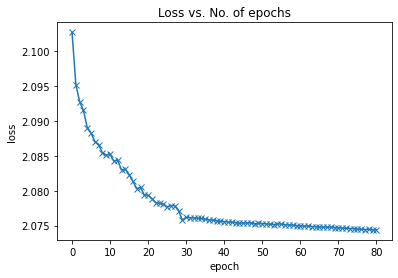

In [22]:
plot_losses(history)

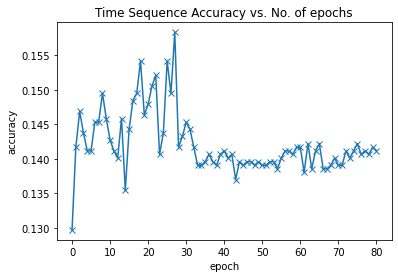

In [23]:
plot_accuracies(history)

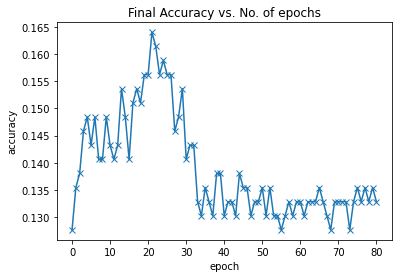

In [24]:
plot_final_accuracies(history)

In [25]:
evaluate(model, test_dataloader)

{'val_loss': 2.074388265609741,
 'val_seq_acc': 0.14114584028720856,
 'final_acc': 0.1328125}

In [26]:
torch.save(model.state_dict(), 'emotion_classification-feedforward.pth')